## ***Load the Document***

In [1]:
from langchain_community.document_loaders import PyMuPDFLoader
import os
pdf_dir = "./deepLearning-book/chapter-3-to-8/"

In [2]:
pdf_files = [os.path.join(pdf_dir, file) for file in os.listdir(pdf_dir) if file.endswith(".pdf")]


In [3]:
pdf_files

['./deepLearning-book/chapter-3-to-8/d2l-en-122-164.pdf',
 './deepLearning-book/chapter-3-to-8/d2l-en-247-272.pdf',
 './deepLearning-book/chapter-3-to-8/d2l-en-207-246.pdf',
 './deepLearning-book/chapter-3-to-8/d2l-en-165-206.pdf',
 './deepLearning-book/chapter-3-to-8/d2l-en-308-364.pdf',
 './deepLearning-book/chapter-3-to-8/d2l-en-273-307.pdf']

In [4]:
# Load and combine all chapters
all_documents = []
for pdf_file in pdf_files:
    loader = PyMuPDFLoader(pdf_file)
    docs = loader.load()
    all_documents.extend(docs)

In [5]:
len(all_documents)

243

## **Semantic Chunking**

In [6]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
load_dotenv()

True

In [ ]:
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [11]:
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

In [12]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/Users/murtazanaiyar/Desktop/Github@MN/AgenticAi/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
len(embeddings.embed_query("Test"))

768

In [14]:
from langchain_experimental.text_splitter import SemanticChunker

text_splitter = SemanticChunker(
    embeddings=embeddings,
    breakpoint_threshold_type="percentile",  # or "standard_deviation"
    breakpoint_threshold_amount=92.5,        # slightly more aggressive than 95.0 (default)
    min_chunk_size=300                       # ensures no tiny chunks
)


In [15]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

In [16]:
chunk_docs = text_splitter.split_documents(all_documents)
len(chunk_docs)

1311

## *Vector Store*

In [17]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore import InMemoryDocstore

### 4 different indexing

In [18]:
# index = faiss.IndexFlat(768)
# index = faiss.IndexIVF(768)
# index = faiss.IndexHNSW(768)
index = faiss.IndexFlatL2(768)

In [19]:
## create VectorStore

vectoStore = FAISS(
    index=index,
    embedding_function=embeddings,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
    
)

In [20]:
vectoStore.add_documents(chunk_docs)

['adc2cc14-f1dd-4a6c-ad29-2661b8228e6b',
 '02e8e43f-1497-4ee1-827f-4cde03621a65',
 'c45b4c3f-d5fb-4a5f-8b54-33e0fbe1ffb8',
 '042a4471-9a04-4792-88c7-0b821f28234a',
 'aabd26b2-12ce-43a4-8a33-5ae7dd00c658',
 '5d5c79a4-363e-44a3-aff6-9e53fbdaa1e3',
 'cebdf4f9-19bc-4d23-8b2b-884450bf1839',
 '46b15a6b-3093-4afa-ba08-51e36d368e46',
 'e43021c7-2321-4d63-97a5-91c9f8227fe3',
 'fa8110ee-77c2-4ddd-8876-bc774f75fc81',
 'e153af70-0cd6-4a7a-a78e-0e4a928e6553',
 '0d468e7a-8ab3-4535-b10e-b31829ffe703',
 '2fb72fe8-7136-49ff-8743-f48c8b7bc098',
 '048ea50b-b941-48e4-83e8-0409a1ee3733',
 'da9b5c95-9d60-43f0-80fc-8fb2064d4c0c',
 '8f0de541-2294-417c-b815-ae571476e16b',
 'ad189ce2-0bf2-4879-be39-7b6a27afcc40',
 '4677860a-9e2f-4205-a8b3-c4799fecc9d5',
 'cb9d5a9e-a1ee-4cbc-bf5a-96de5d23b62e',
 'd9d94a1b-68ce-41b6-8dfd-161a1160cccb',
 '7ab0a22d-67a0-414e-b076-b41e9bc75113',
 '2652305c-8c60-4c3f-8caf-03606864bea4',
 'e3aad21d-c7ba-46cf-87dd-05dcf2c57cca',
 '266449ce-2738-451c-8704-834d9060f686',
 'a6701252-7838-

## save the db

In [21]:
vectoStore.save_local("d2l-vdb")

In [22]:
retriever = vectoStore.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

In [23]:
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [24]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    print()
    return context_text

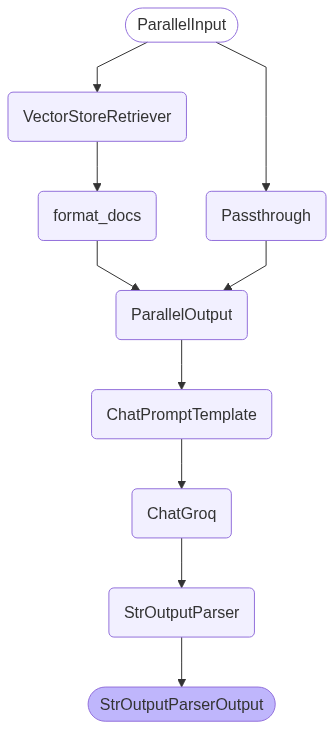

In [25]:
from IPython.display import display, Image

rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)


display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [26]:
rag_chain.invoke("Why multilayer perceptron is important?")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'Multilayer perceptrons are important because they are the simplest type of deep network, consisting of multiple layers of fully connected neurons. They are a fundamental building block of deep learning algorithms. They allow for complex representations of data, enabling the learning of optimal predictors.'

In [27]:
rag_chain.invoke("Why lstm is batter then rnn")

"I don't know why LSTM is better than RNN based on the provided context. The context discusses the challenges of optimizing sigmoid activation functions and the ease of implementing deep learning models, but it does not compare LSTMs and RNNs directly. It mentions that sigmoids are important in later chapters on recurrent neural networks, but does not provide a clear answer."

In [29]:
query = "What is the purpose of the softmax function in classification tasks?"
rag_chain.invoke(query)

'The softmax function is used in classification tasks to give a vector of estimated probabilities. It allows us to interpret the output of a model as a probability distribution over classes. The softmax function enables maximum likelihood estimation to optimize the accuracy of the mapping from features to probabilities.'

## **Improve the system like use `Re-rank`**

In [30]:
from pydantic import BaseModel, Field

class RankedDoc(BaseModel):
    doc_id: int = Field(..., description="Index of the document in the original retrieval list")
    score: int = Field(..., description="Relevance score from 1 to 5")

In [31]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=RankedDoc)

In [32]:
from langchain_core.prompts import PromptTemplate

rerank_prompt = PromptTemplate(
    template= """
    You are an expert document reranker. Here you will got the user question {question} \n\n
    and the retrieve docs now you compare based on the below instruction. and the retrieve docs is: \n {retrieve_docs}

Instructions:
- Give a score between 1 (least relevant) and 5 (most relevant).
- Return a list of RankedDoc with doc_id (position in original list) and score.

and prove the output follow this formate instruction {formatted_docs}.
    """,
    input_variables=["question", "retrieve_docs"],
    partial_variables= {
        "formatted_docs": parser.get_format_instructions()
    }
)


def format_retrieved_docs(docs, question = query):
    formatted = []
    for idx, doc in enumerate(docs):
        formatted.append(f"[{idx}] {doc.page_content}")
    formed_value =  "\n\n".join(formatted)
    print(formed_value)
    reranker_chain = rerank_prompt | llm | parser
    reranked = reranker_chain.invoke(
        {
            "question": question,
            "retrieve_docs": formed_value
        }
    )
    print(reranked)
    # now i got the result of rank document and have to process now if score is less then 2 it will be exclude amd more then 2 will be my actual document its goes to the llm.
    selected_docs = [docs[item.doc_id] for item in reranked if item.score >= 3]
    return selected_docs
    



In [34]:
from IPython.display import display, Image

rag_chain = (
    {
        "context": retriever | format_retrieved_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)


# display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [35]:

rag_chain.invoke(query)

[0] sion, we use a single-layer neural network. And since the calculation of each output, 𝑜1, 𝑜2,
and 𝑜3, depends on every input, 𝑥1, 𝑥2, 𝑥3, and 𝑥4, the output layer can also be described as
a fully connected layer.
t
Fig. 4.1.1
Softmax regression is a single-layer neural network.
For a more concise notation we use vectors and matrices: o = Wx+b is much better suited
for mathematics and code. Note that we have gathered all of our weights into a 3×4 matrix
and all biases b ∈R3 in a vector.

[1] take care of this automatically.
4.1.2 Loss Function
Now that we have a mapping from features x to probabilities ˆy, we need a way to optimize
the accuracy of this mapping. We will rely on maximum likelihood estimation, the very
same method that we encountered when providing a probabilistic justification for the mean
squared error loss in Section 3.1.3.
Log-Likelihood
The softmax function gives us a vector ˆy, which we can interpret as the (estimated) con-

[2] do not need to compute the softmax

OutputParserException: Failed to parse RankedDoc from completion [{"doc_id": 0, "score": 2}, {"doc_id": 1, "score": 4}, {"doc_id": 2, "score": 3}]. Got: 1 validation error for RankedDoc
  Input should be a valid dictionary or instance of RankedDoc [type=model_type, input_value=[{'doc_id': 0, 'score': 2...doc_id': 2, 'score': 3}], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 